# Practical demonstration of the CWT NaN COI

**Problem statement**: DTS data is complex, often multi-dimensional and subject to various types of data errors from gaps to radiation artifacts. These periods of poorer/missing data create a problem for performing the CWT.

Here I provide a practical demonstration of using the NaN COI, taking particular care to show off how to use it when creating spatially and temporally complex masks.


In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pywt
import pycwt as wavelet
from pycwt.helpers import find
import scipy
import pyfocs

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string
import datetime
import pandas as pd
import copy
import yaml
import time
import seaborn as sns
from matplotlib.dates import DateFormatter

# This script generates a number of useless warnings
# like oh no you divided by zero, which is quite
# normal for this sort of analysis.
import warnings
warnings.filterwarnings("ignore")

/Users/karllapo/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## Directories

Note, these data can be acquired from the Large-eddy Observatory, Voitsumra Experiment 2019 (LOVE19) Zenodo repository (doi: 10.5281/zenodo.4312976). These follow my local directories and cannot be run directly). This notebook is for illustrative purposes only.

In [2]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra')

# DTS data
dir_essd = os.path.join(dir_pre, 'love_dts/ESSD-repository/')
dir_dts_essd = os.path.join(dir_essd, 'FODS/outer-array')

# Met data
dir_aws_data = os.path.join(dir_essd, 'AWS')
dir_csat_fl = os.path.join(dir_essd, 'CSAT fluxes')
dir_csat_ts = os.path.join(dir_essd, 'CSAT 20Hz')

# Figures
dir_print = os.path.join(
    dir_pre, 'figures/DTS/outer_array/scale-analysis'
)

## Wavelet functions

In [3]:
os.chdir(os.path.join(dir_pre, 'notebook/wavelets/helper_functions'))
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt

## Format plots

In [5]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# Gather Data

## Metadata

- times of flights
- csat/tower FODS height corrections

In [6]:
# Specify periods to examine
dts_times = {
    'LOVE-Flyfox-190722': ['2019-07-22 3:18', '2019-07-22 6:10'],
}


## Load and Process the DTS surface arrays

One of the challenges in how I named and labelled the sections is that the long arms of the outer rectangles are named "XX1" and "XX2". It is desirable to be able to call both segments as one segment rather than two shorter ones. To do this we need to:

1) Open up the DTS data

2) Grab the entire longer segment.

3) Remove overlapping indices at vertices in the array

4) Rename the longer segment from "XX1" and "XX2" to just "XX"

5) Concatenate the entire array back together

After those steps, I do some additional cleaning, for instance creating a "gappy" record with NaNs in data gaps instead of no data and removing duplicate time steps.

In [7]:
NE_names = {'ss': ['OR_NE1', 'OR_NE2'],
            'p1': ['IR_NE1', 'IR_NE2'],
           }

SW_names = {'ss': ['OR_SW1', 'OR_SW2'],
            'p1': ['IR_SW1', 'IR_SW2'],
           }

# Dictionary containers for the outer rim and inner rim components
outer_dict = {}
inner_dict = {}
# Container for the approximate regime times for each flight
regimes = {}

for ft in dts_times:
    print(ft)
        
    # We load the entire day of surface DTS data for each flight
    t1 = pd.Timestamp(dts_times[ft][0])
    t2 = pd.Timestamp(dts_times[ft][1])
    date_str = '2019-07-' + str(t1.day)
    
    # Gather the DTS data
    os.chdir(dir_dts_essd)
    filestr = '*' + date_str + '*_matr-inv_unheated.nc'
    ss_cold = xr.open_mfdataset(filestr, combine='by_coords', chunks={'time': 24}).load()

    filestr = '*' + date_str + '*_matr-inv_p1.nc'
    p1 = xr.open_mfdataset(filestr, combine='by_coords', chunks={'time': 24}).load()
    
    # Inner rim
    inner = p1
    
    # Stictch together two segments to create a super segment
    inner_sw = inner.where(
        (inner.p1==SW_names['p1'][0]) | (inner.p1==SW_names['p1'][1]),
        drop=True)
    inner_ne = inner.where(
        (inner.p1==NE_names['p1'][0]) | (inner.p1==NE_names['p1'][1]),
        drop=True)
    
    # Handle the overlapping indices from stitching together
    inner_ne = pyfocs.labeler.xr_unique_index(inner_ne.swap_dims({'xyz': 'x'}), 'x')
    inner_ne = inner_ne.swap_dims({'x': 'p1'})
    inner_ne.coords['p1'] = ['IR_NE'] * inner_ne.p1.size
    inner_sw = pyfocs.labeler.xr_unique_index(inner_sw.swap_dims({'xyz': 'x'}), 'x')
    inner_sw = inner_sw.swap_dims({'x': 'p1'})
    inner_sw.coords['p1'] = ['IR_SW'] * inner_sw.p1.size

    inner_nw = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_NW'}]
    inner_se = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_SE'}]
    inner = xr.concat([inner_se, inner_nw, inner_sw, inner_ne], dim='p1')
    inner = inner.rename({'p1': 'unheated'})

    # Outer rim
    outer = ss_cold
    
    # Stictch together two segments to create a super segment
    outer_sw = outer.where(
        (outer.unheated==SW_names['ss'][0]) | (outer.unheated==SW_names['ss'][1]),
        drop=True)
    outer_ne = outer.where(
        (outer.unheated==NE_names['ss'][0]) | (outer.unheated==NE_names['ss'][1]),
        drop=True)
    
    # Handle the overlapping indices from stitching together
    outer_ne = pyfocs.labeler.xr_unique_index(outer_ne.swap_dims({'xyz': 'x'}), 'x')
    outer_ne = outer_ne.swap_dims({'x': 'unheated'})
    outer_ne.coords['unheated'] = ['OR_NE'] * outer_ne.unheated.size
    outer_sw = pyfocs.labeler.xr_unique_index(outer_sw.swap_dims({'xyz': 'x'}), 'x')
    outer_sw = outer_sw.swap_dims({'x': 'unheated'})
    outer_sw.coords['unheated'] = ['OR_SW'] * outer_sw.unheated.size

    outer_nw = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_NW'}]
    outer_se = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_SE'}]

    outer = xr.concat([outer_se, outer_nw, outer_ne, outer_sw], dim='unheated')
    
    # Create a "gappy" record with NaNs so that we don't have unreasonable
    # wavelet power across data gaps.
    t_continuous = pd.date_range(
        start=pd.Timestamp(p1.time.values[0]),
        end=pd.Timestamp(p1.time.values[-1]),
        freq='5s'
    )
    inner = pyfocs.labeler.xr_unique_index(inner, 'time')
    inner = inner.reindex(time=t_continuous, tolerance='5s', method='nearest')

    outer = pyfocs.labeler.xr_unique_index(outer, 'time')
    outer = outer.reindex(time=t_continuous, tolerance='5s', method='nearest')

    # dictionary containers
    outer_dict[ft] = outer

    inner_dict[ft] = inner

LOVE-Flyfox-190722


In [8]:
inner_comp = ['IR_SE', 'IR_NW', 'IR_NE', 'IR_SW']
outer_comp = ['OR_SE', 'OR_NW', 'OR_NE', 'OR_SW']

# CWT

## Wavelet spectrum resolving scales in time

These plots will average acros scales in the end, but first let's get some intuition for them based on the time series from two points at either end of the field. The data are gappy. That means we either need to somehow account for the effect of the jump in the data.

Demonstrate how/that the `nan_sequences` function works. It returns both the indicies of the NaN block's beginning and end as well as a slice object. Both can be used to index contiguous sections of NaNs depending on the needs of the user.

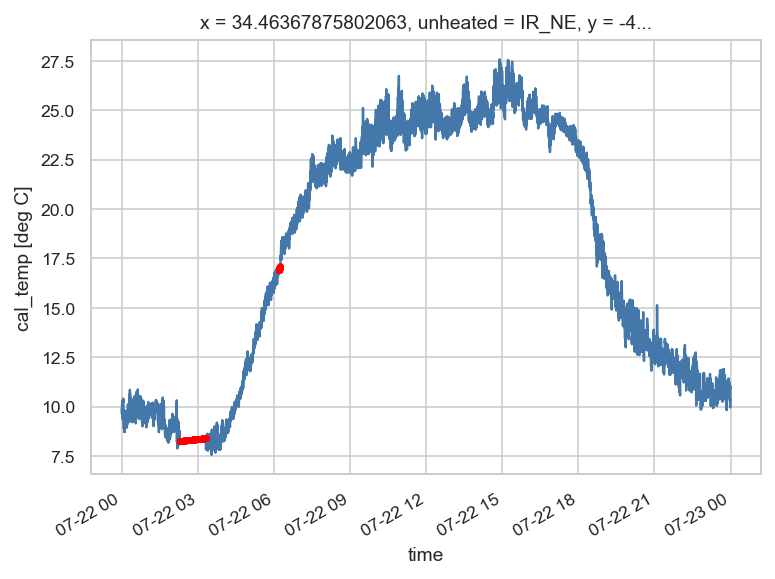

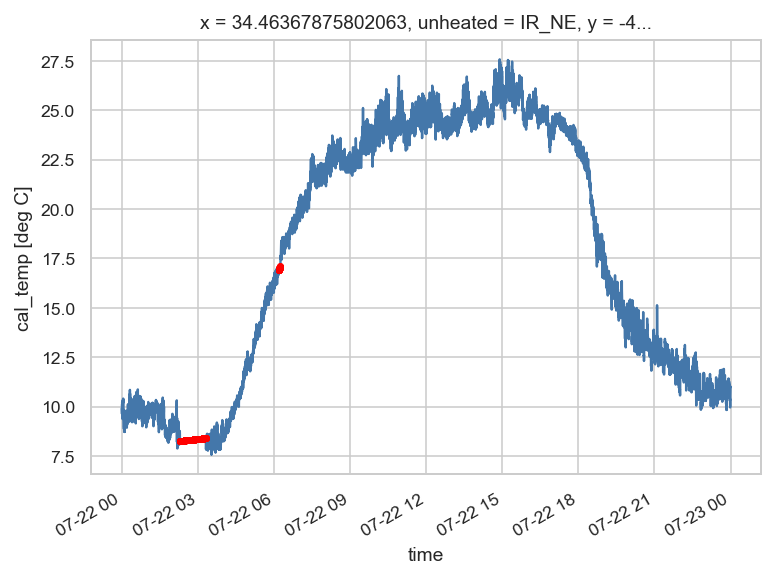

In [11]:
y = -40
ft = 'LOVE-Flyfox-190722'
section_name = 'IR_NE'
ds = inner_dict[ft].sel(unheated=section_name).swap_dims({'unheated': 'y'})

signal = ds.cal_temp.sel(y=y, method='nearest')#.sel(time=tslice)
signal_int = signal.interpolate_na(dim='time')

dt = int(ds.attrs['dt'][:-1])
nan_seq_ind, nan_seq_slc, nan_seq_len = cwt_stat.nan_sequences(signal, dt, dim='time', units='seconds')

# Using the indices
signal_int.plot()
for n in range(len(nan_seq_ind)):
    signal_int.isel(time=slice(nan_seq_ind[n][0], nan_seq_ind[n][1])).plot(marker='.', color='r')
    
# Using the slice objects
plt.figure()
signal_int.plot()
for n in range(len(nan_seq_ind)):
    signal_int.sel(time=nan_seq_slc[n]).plot(marker='.', color='r')


In [13]:
nan_seq_ind, nan_seq_slc, nan_seq_len

([[1651, 2380], [4450, 4497]],
 [slice(Timestamp('2019-07-22 02:17:40'), Timestamp('2019-07-22 03:18:25'), None),
  slice(Timestamp('2019-07-22 06:10:55'), Timestamp('2019-07-22 06:14:50'), None)],
 [729, 47])

### Account for nan gaps in the cwt workflow

Next is to determine the gap length and masking CWT scales below that gap length during the gap. We will in effect reconstruct the COI around each gap.

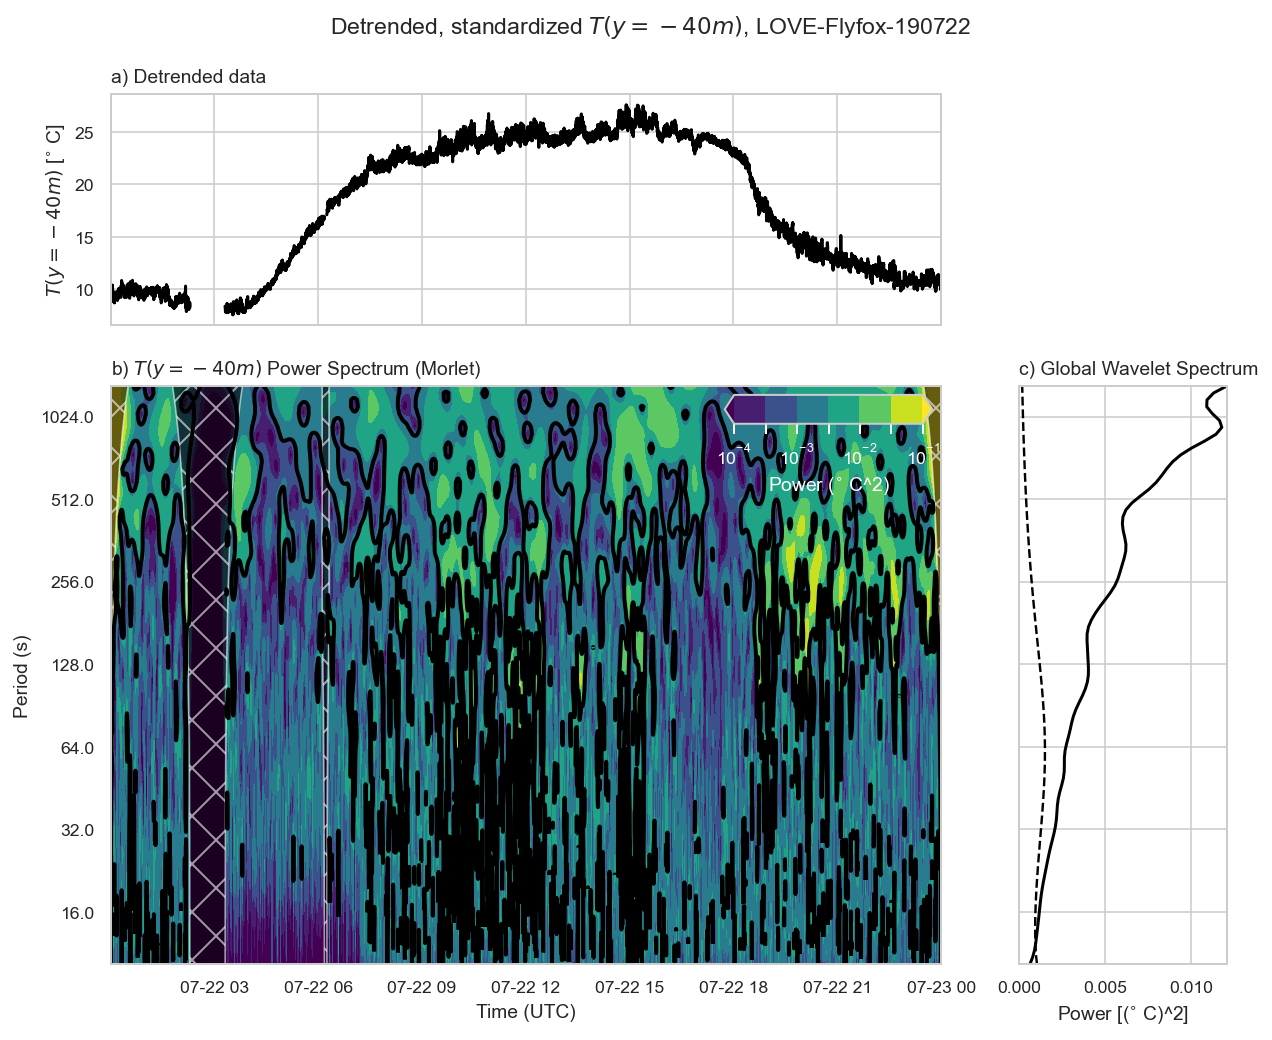

In [15]:
yloc = [-40]#, 0, 40] 
mother = wavelet.Morlet()

# Found to be the residual layer's rednoise coefficient on days with a clear
# SBL-residual layer differentiation.
sig_lvl = 0.99
variance = 0.04
alpha = 0.6

for y in yloc:
    signal = ds.cal_temp.sel(y=y, method='nearest')
    nanmask = np.isnan(signal)
    signal_int = signal.interpolate_na(dim='time')

    dt_td64 = scipy.stats.mode(ds.time.diff(dim='time'))[0]
    dx = pd.to_timedelta(dt_td64, unit='ns').seconds[0]
    x = signal_int.time.values
    N = signal_int.size
    signal = signal_int.values
    
    (signal_norm, period, coi,
     power, glbl_signif, glbl_power,
     sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
        signal, dx, x, mother, 
        octaves=None,
        scales_to_avg=None,
        glbl_power_var_scaling=False,
        norm_kwargs={'detrend': False, 'standardize': False},
        variance=variance,
        sig_kwargs={
            'alpha': alpha,
            'sig_lvl': sig_lvl,
        },
    )

    title = r'Detrended, standardized $T(y={y}m)$, {ft}'.format(ft=ft, y=y)
    label = r'$T(y={y}m)$'.format(y=y)
    units = '$^{\circ}$ C'
    scale_units = 's'

    fig_labels = {
        'title': title,
        'label': label,
        'units': units,
        'scale_units': scale_units,
        'mother': mother.name,
        'xlabel': 'Time (UTC)'
    }
    
    coi_mask = cwt_stat.nan_coi(nan_seq_ind, nan_seq_len, coi, period, signal_int, 5)
    signal_norm = np.ma.masked_where(nanmask, signal_norm)

    cwt_plt.plot_wv_power(
        signal_norm=signal_norm,
        x=x,
        dx=dx,
        period=period,
        power=power,
        coi=coi_mask,
        glbl_signif=glbl_signif,
        sig95=sig95,
        glbl_power=glbl_power,
        fig_kwargs=None,
        fig_labels=fig_labels,
        include_colorbar=True,
    )
    

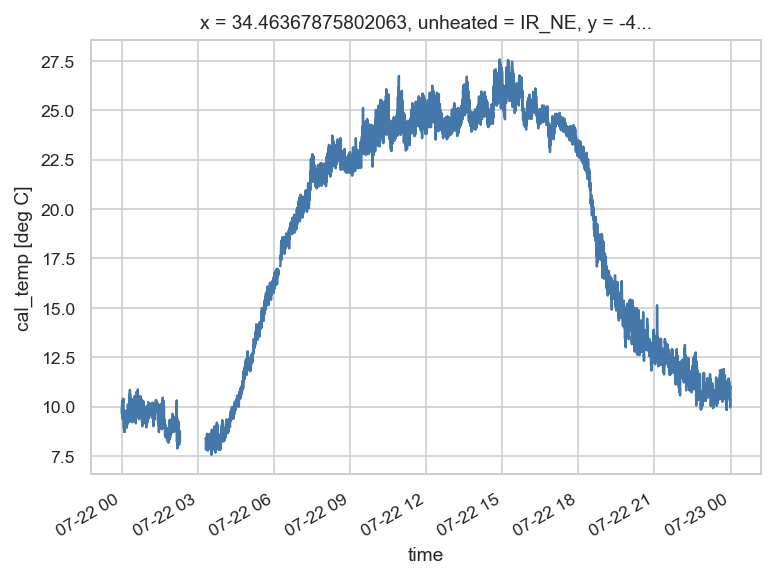

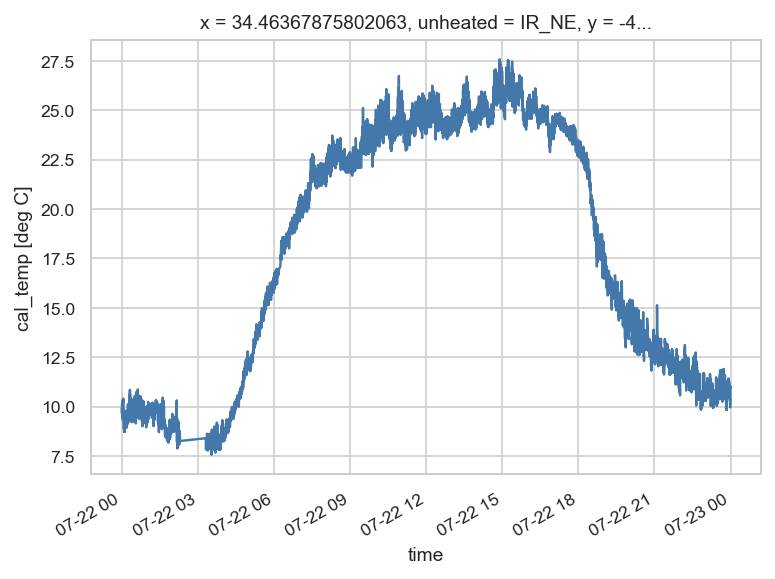

In [21]:
signal = ds.cal_temp.sel(y=y, method='nearest')
signal.plot()
nanmask = np.isnan(signal)
signal_int = signal.interpolate_na(dim='time')
plt.figure()
signal_int.plot()

More closely examining the coi nan masking...

(0.0, 1000.0)

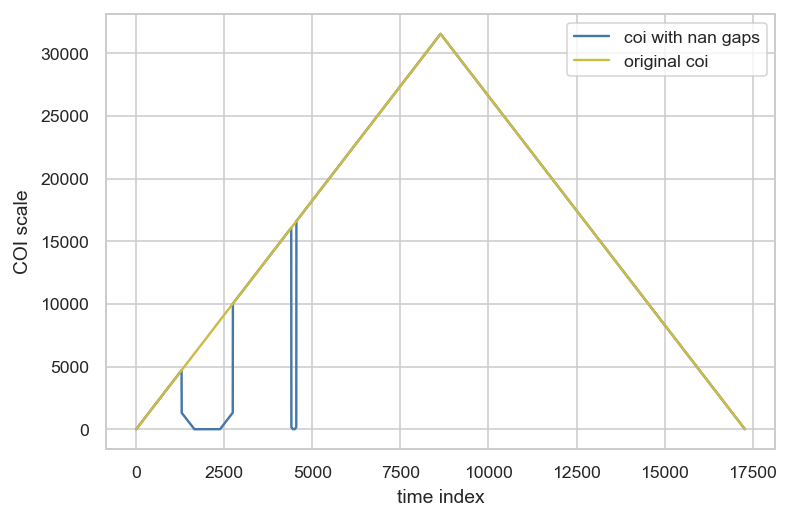

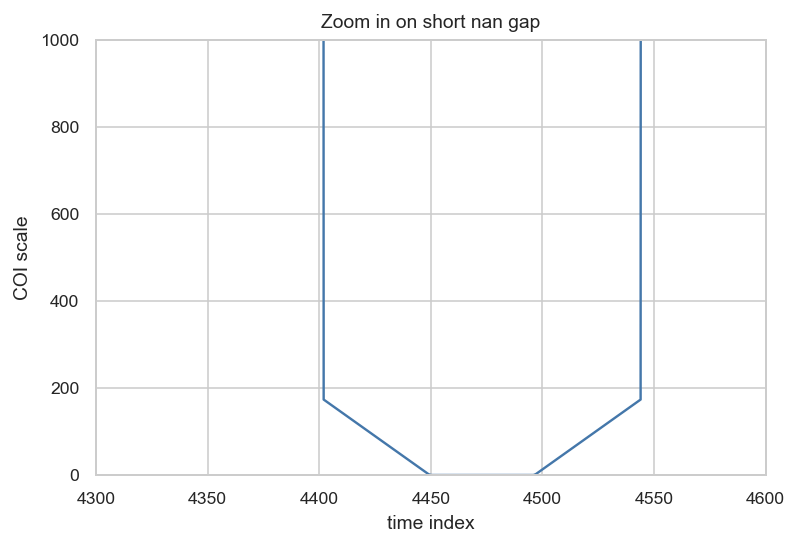

In [10]:
coi_mask = cwt_stat.nan_coi(nan_seq_ind, nan_seq_len, coi, period, signal_int, 5)
plt.plot(coi_mask, label='coi with nan gaps')
plt.plot(coi, label='original coi')
plt.gca().set_ylabel('COI scale')
plt.gca().set_xlabel('time index')
plt.gca().legend()

plt.figure()
plt.gca().set_title('Zoom in on short nan gap')
plt.plot(coi_mask)
plt.plot(coi)
plt.gca().set_ylabel('COI scale')
plt.gca().set_xlabel('time index')
plt.gca().set_xlim(4300, 4600)
plt.gca().set_ylim(0, 1000)

So here we have a COI added around each nan gap. The COI takes into account the length of the nan gap. Shorter gaps produce no additional masking at longer scales, as the linear approximation from the nan interpolation should introduce negligible edge effects at the longer scales. We just exclude the longer scales that are centered on the nan gap.

# Complex data masks and the COI

In [11]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_FlyFOX-A')
dir_wavelet_ff_a = os.path.join(dir_pre, 'kl-data/FlyFOX-A_wavelets')

In [12]:
os.chdir(dir_wavelet_ff_a)
ft = 'FLYFOX-A_180910_IceFOX'

ft_mrlt_t = xr.open_dataset(ft + '.cwt-Morlet.nc')
ft_mrlt_xyz = xr.open_dataset(ft + '.spatial-cwt-Morlet.nc')

In [13]:
# UTC flight times
os.chdir(dir_wavelet_ff_a)
ft = 'FLYFOX-A_180918_IceFOX'

fname = '{}.{}.scale_avg_stability.v1-2021-06-16.nc'.format(ft, 'Morlet')
ft_mrlt_t_stab = xr.open_dataset(fname)
ft_mrlt_t_stab = ft_mrlt_t.drop(['temp_a', 'temp_d', 'theta_v'])

fname = '{}.{}.spatial.scale_avg_stability.v1-2021-06-16.nc'.format(ft, 'Morlet')    
ft_mrlt_xyz_stab = xr.open_dataset(fname)
ft_mrlt_xyz_stab = ft_mrlt_xyz.drop(['temp_a', 'temp_d', 'theta_v'])


Build the mask of data to exclude:

Text(0.5, 1.0, 'Unmasked region without artifacts')

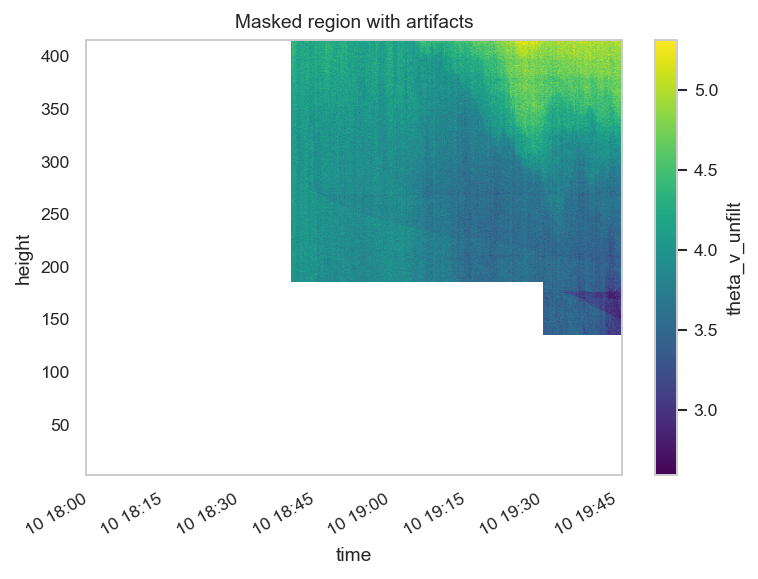

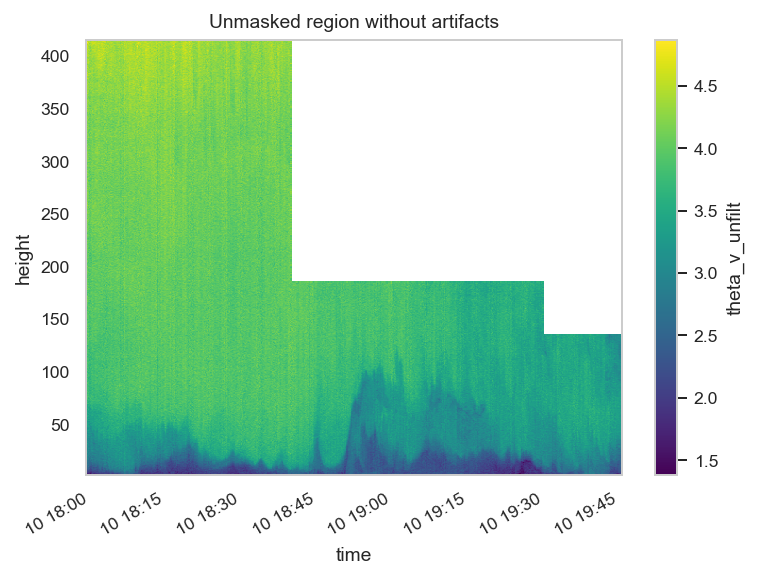

In [14]:
mask = (
    (
        (ft_mrlt_t.z > 185)
        & (ft_mrlt_t.time > pd.Timestamp('2018-09-10 18:40')))
    | 
    (
        (ft_mrlt_t.z > 135)
        & (ft_mrlt_t.time > pd.Timestamp('2018-09-10 19:30'))
    )
)

ft_mrlt_t.theta_v_unfilt.where(mask).T.plot()
plt.gca().set_title('Masked region with artifacts')

# Reassign and verify visually
plt.figure()
ft_mrlt_t.theta_v_unfilt.where(~mask).T.plot()
plt.gca().set_title('Unmasked region without artifacts')

Build a class that inherits from xarray and add the nan_sequence and nan_coi methods.

In [16]:
da = ft_mrlt_t.theta_v_unfilt.where(~mask)

dt_td64 = scipy.stats.mode(da.time.diff(dim='time'))[0]
dt = pd.to_timedelta(dt_td64, unit='ns').seconds[0]

# Build the coi mask for the period with the radiation masking
ft_mrlt_t['coi_mask'] = (('time', 'z'), np.zeros_like(ft_mrlt_t.theta_v_unfilt.values))
for z in da.z:
    signal = da.sel(z=z, method='nearest')
    nan_seq_ind, nan_seq_slc, nan_seq_len = cwt_stat.nan_sequences(
        signal,
        dt,
        dim='time',
        units='seconds'
    )
    ft_mrlt_t['coi_mask'].loc[dict(z=z)] = cwt_stat.nan_coi(
        nan_seq_ind,
        nan_seq_len,
        ft_mrlt_t.coi,
        ft_mrlt_t.period,
        signal,
        dt
    )

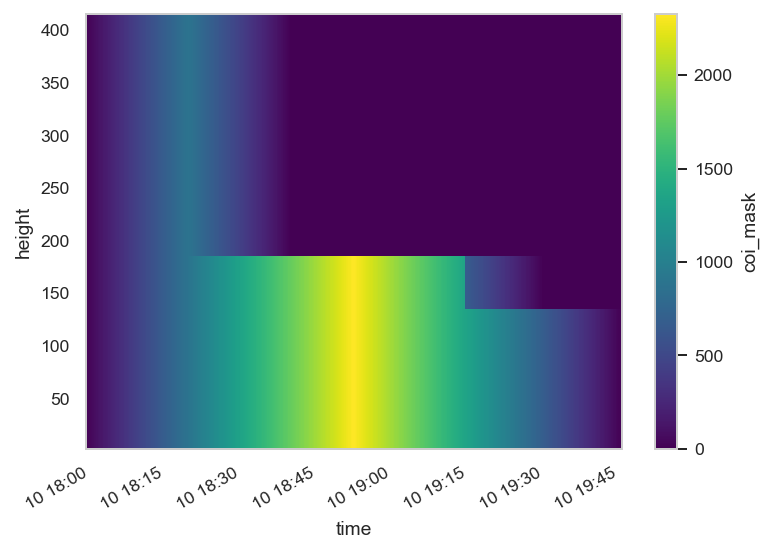

In [17]:
ft_mrlt_t['coi_mask'].T.plot()

The idea here is that the COI mask will be applied after computing the wavelets, as opposed to masking out these periods before hand. The motivation is that a longer scale CWT (e.g., something like 1000s) won't care about the small perturbation step function from the radiation artifacts, so we don't need to mask those scales. But, we do need to mask the shorter scales at which the radiation artifacts would be relevant, which we can estimate directly through the COI.

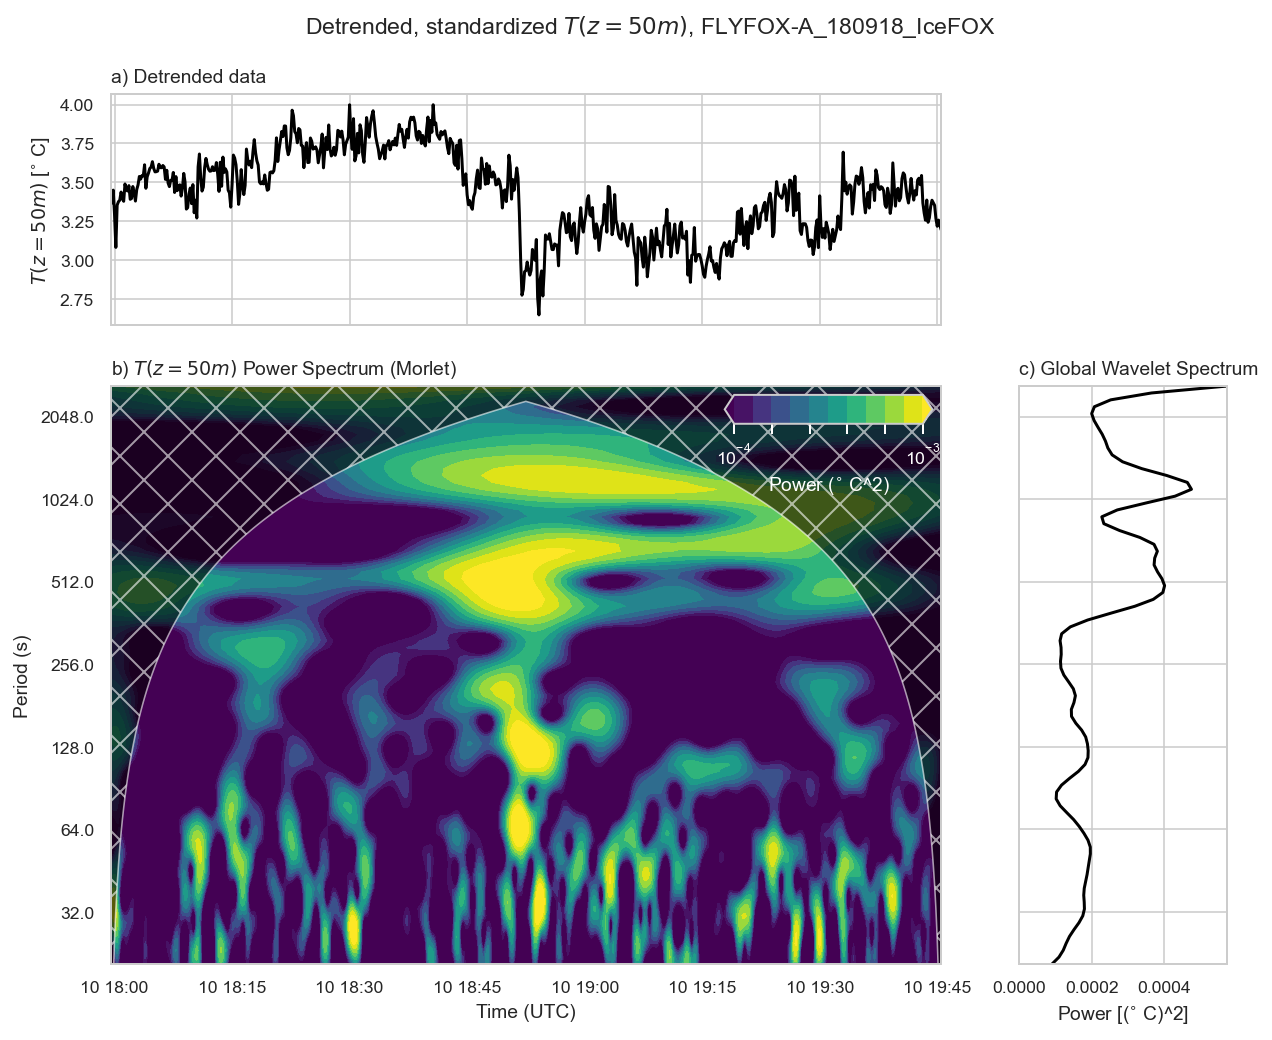

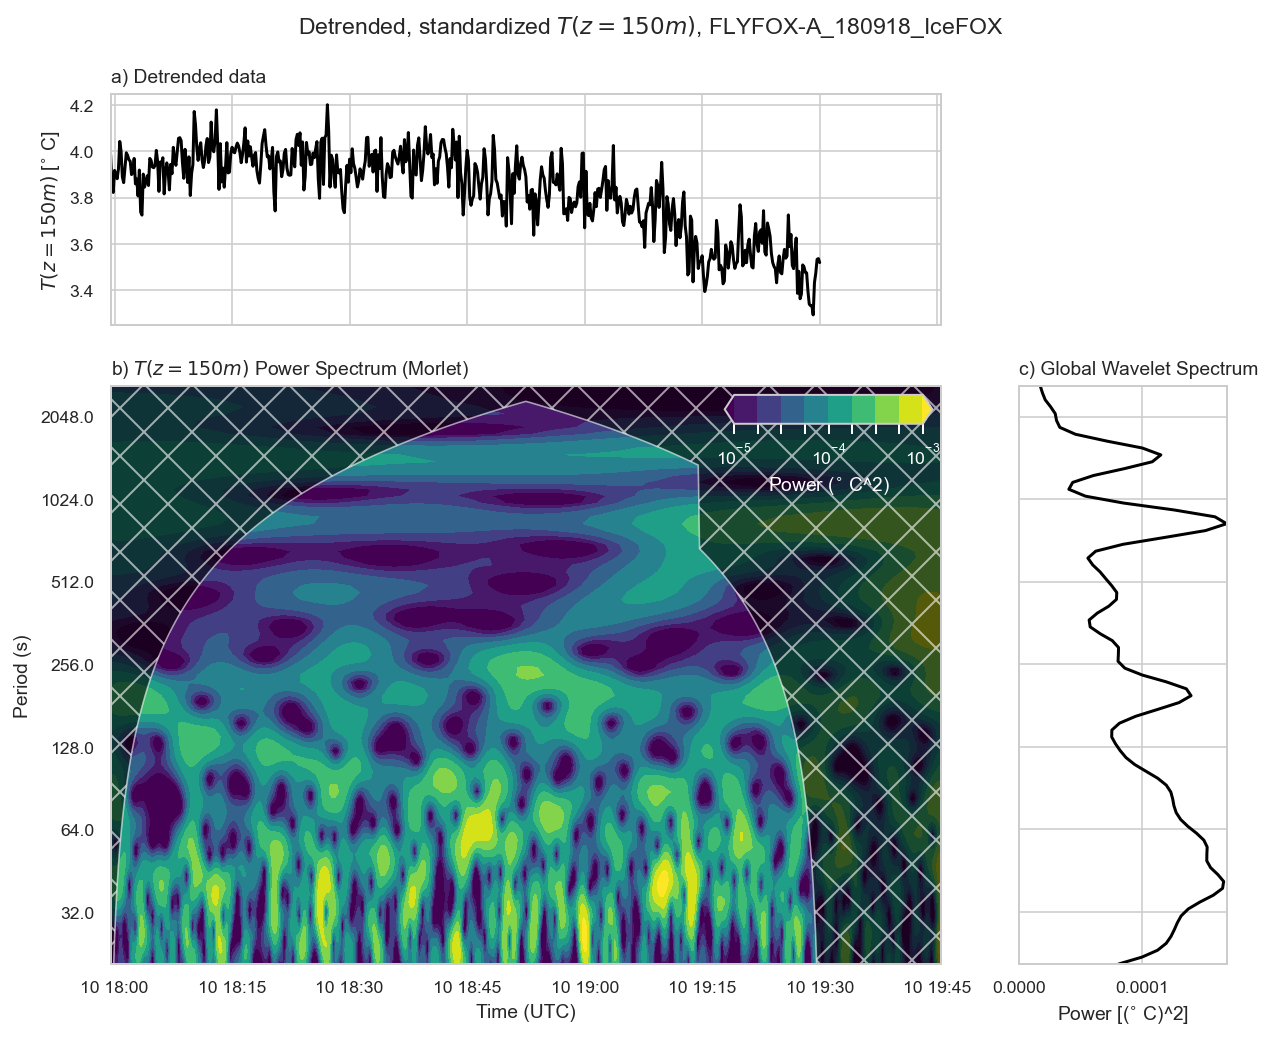

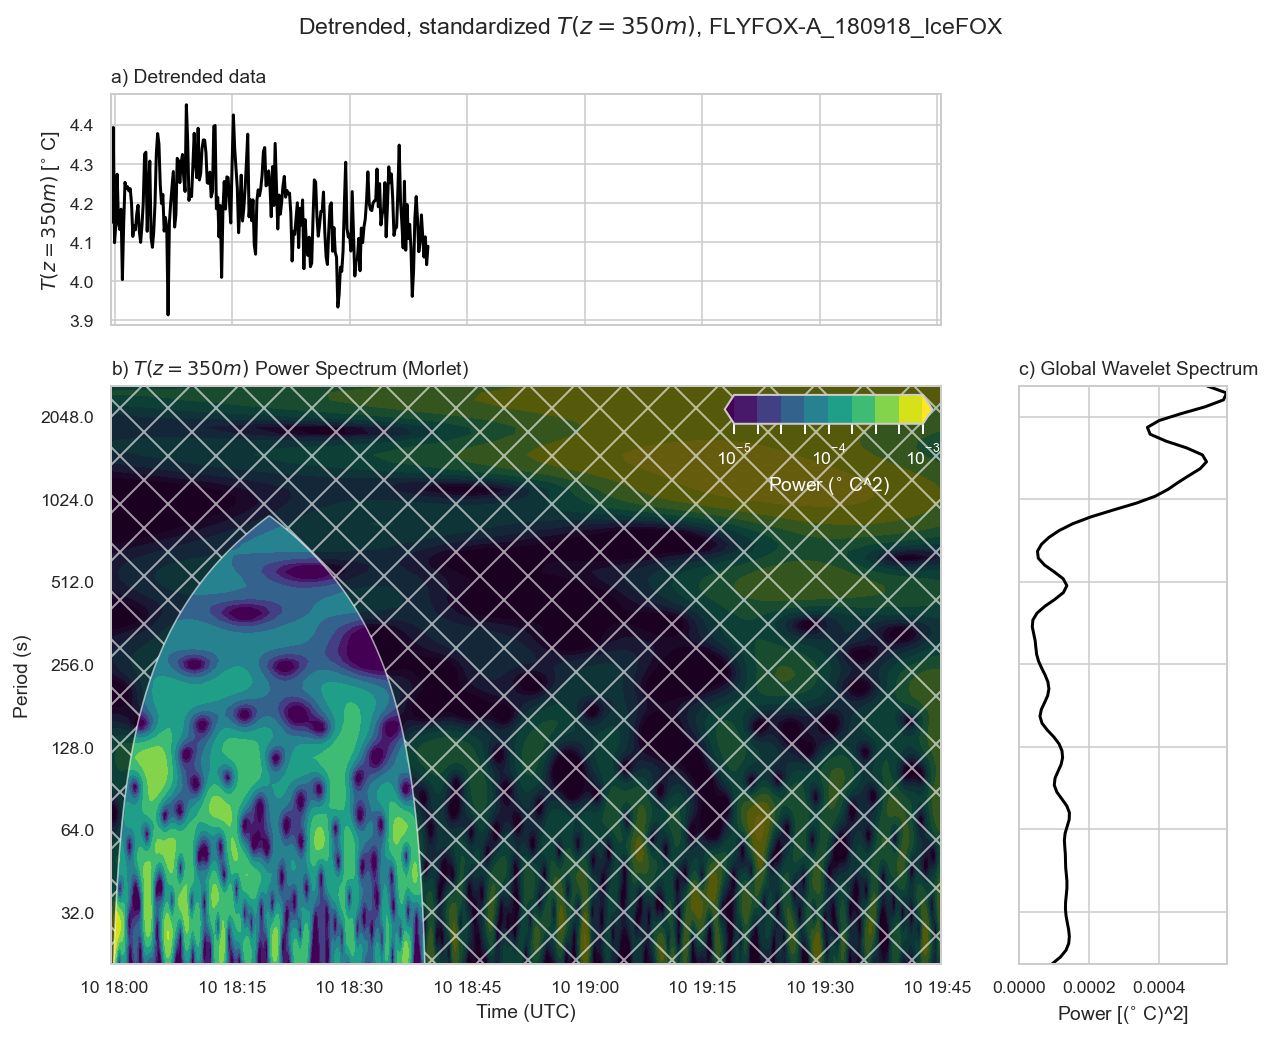

In [18]:
zlist = [50, 150, 350] 
mother = wavelet.Morlet()

for z in zlist:
    signal = ft_mrlt_t.sel(z=z, method='nearest')

    title = r'Detrended, standardized $T(z={z}m)$, {ft}'.format(ft=ft, z=z)
    label = r'$T(z={z}m)$'.format(z=z)
    units = '$^{\circ}$ C'
    scale_units = 's'

    fig_labels = {
        'title': title,
        'label': label,
        'units': units,
        'scale_units': scale_units,
        'mother': mother.name,
        'xlabel': 'Time (UTC)'
    }

    cwt_plt.plot_wv_power(
        signal_norm=signal.theta_v_unfilt.where(~mask.sel(z=z, method='nearest')),
        x=signal.time.values,
        dx=5,
        period=signal.period,
        power=signal.power,
        coi=signal.coi_mask,
        fig_labels=fig_labels,
        include_colorbar=True,
    )
    

The global power is calculated from the data and still needs to be adjusted, as in the theoretical notebook.